Importaciones

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime

Carga de CSVs (no todos son necesarios)

In [ ]:
# Cargar los archivos CSV
sellers = pd.read_csv('sellers.csv')
reviews = pd.read_csv('reviews.csv')
products = pd.read_csv('products.csv')
orders = pd.read_csv('orders.csv')
order_payments = pd.read_csv('order_payments.csv')
order_items = pd.read_csv('order_items.csv')
customers = pd.read_csv('customers.csv')

Unión de CSVs en uno sólo. Únicamente se utilizan 5 de ellos, no los 8.

In [ ]:
# Unir los DataFrames
df = pd.merge(orders, customers, on='customer_id')
df = pd.merge(df, order_payments, on='order_id')
df = pd.merge(df, order_items, on='order_id')
df = pd.merge(df, reviews, on='order_id', how='left')

# Mostrar las primeras filas del DataFrame
print(df.head())

                           order_id                       customer_id  \
0  1582d3d1c7a4c1fd7b5857c7e6c084bb  c1d75069901ff3b203405a36de0c653b   
1  1582d3d1c7a4c1fd7b5857c7e6c084bb  c1d75069901ff3b203405a36de0c653b   
2  1582d3d1c7a4c1fd7b5857c7e6c084bb  c1d75069901ff3b203405a36de0c653b   
3  770a0411b7850b3d8f8c55cd41316eb9  d12b894fe079585668a12171ef6d3a9c   
4  64cafa9458e5376e77efcce3c095e541  1df65b523d72a0bb1e1716380fb5cf81   

      status   purchase_timestamp          approved_at delivered_courier_date  \
0  delivered  2022-10-02 10:56:33  2022-10-02 11:07:15    2022-10-04 19:55:00   
1  delivered  2022-10-02 10:56:33  2022-10-02 11:07:15    2022-10-04 19:55:00   
2  delivered  2022-10-02 10:56:33  2022-10-02 11:07:15    2022-10-04 19:55:00   
3  delivered  2023-07-24 20:41:37  2023-07-26 03:24:27    2023-07-26 14:31:00   
4  delivered  2023-08-08 08:38:49  2023-08-08 08:55:23    2023-08-08 13:50:00   

  delivered_customer_date estimated_delivery_date  \
0     2022-10-10 21:2

Limpieza de la tabla:
- Eliminación de duplicados
- Relleno de nulos
- Cambio de formato de datos (en este caso se puede omitir)
- Cambio de valores erróneos en la columna score
- Eliminación de columnas no necesarias (también se puede omitir)


In [ ]:
# Eliminar duplicados
df.drop_duplicates(inplace=True)

# Rellenar valores nulos
df.fillna({
    'review_id': 'no_review',
    'score': 0,
    'has_comment': 0,
    'review_creation_date': pd.Timestamp.now(),
    'review_answer_timestamp': pd.Timestamp.now()
}, inplace=True)

# Rellenar valores nulos en columnas numéricas y categóricas
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

# Convertir columnas a tipo datetime
df['purchase_timestamp'] = pd.to_datetime(df['purchase_timestamp'])
df['approved_at'] = pd.to_datetime(df['approved_at'])
df['delivered_courier_date'] = pd.to_datetime(df['delivered_courier_date'])
df['delivered_customer_date'] = pd.to_datetime(df['delivered_customer_date'])
df['estimated_delivery_date'] = pd.to_datetime(df['estimated_delivery_date'])
df['review_creation_date'] = pd.to_datetime(df['review_creation_date'])
df['review_answer_timestamp'] = pd.to_datetime(df['review_answer_timestamp'])

# Corregir tipo de dato para la columna 'score'
df['score'] = df['score'].replace('s', 5).astype(float)

# Corregir las fechas incorrectas
df.loc[df['purchase_timestamp'].dt.year == 2222, 'purchase_timestamp'] = df['purchase_timestamp'].apply(
    lambda x: x.replace(year=2022) if x.year == 2222 else x
)

# Filtrar fechas inusuales (por ejemplo, fuera de un rango razonable)
df = df[(df['purchase_timestamp'] >= '2010-01-01') & (df['purchase_timestamp'] <= pd.Timestamp.today())]

# Eliminar columnas no necesarias
columns_to_drop = ['postal_code', 'shipping_limit_date', 'freight_value']
df.drop(columns=columns_to_drop, inplace=True)

Cálculo de nuevas variables que se van a utilizar en el modelo.

Estandarización y normalización.

In [ ]:
# Calcular la fecha actual
current_date = pd.Timestamp.now()

# Calcular los días desde la última compra
df['days_since_last_purchase'] = (current_date - df['purchase_timestamp']).dt.days

# Calcular las características de los clientes
customer_features = df.groupby('customer_id').agg({
    'amount': 'sum',  # Total Gastado
    'order_id': 'count',  # Frecuencia de Compra
    'price': 'mean',  # Valor Medio de Compra
    'review_id': 'count',  # Número de Reseñas
    'score': 'mean',  # Puntuación Media de Reseñas
    'days_since_last_purchase': 'min'  # Días desde la última compra
}).rename(columns={
    'amount': 'total_spent',
    'order_id': 'purchase_frequency',
    'price': 'average_order_value',
    'review_id': 'num_reviews',
    'score': 'avg_review_score'
})

customer_features.drop(index='2a708822a99c99cfff06f8239322b2db', inplace=True)

print(customer_features.describe())

# Estandarizar y normalizar los datos
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features)
customer_df = pd.DataFrame(customer_features_scaled, columns=customer_features.columns, index=customer_features.index)

        total_spent  purchase_frequency  average_order_value   num_reviews  \
count  98664.000000        98664.000000         98664.000000  98664.000000   
mean     171.495362            1.091249           125.944302      1.091249   
std      260.078743            0.499186           190.992923      0.499186   
min       -2.000000            1.000000             0.850000      1.000000   
25%       62.370000            1.000000            41.990000      1.000000   
50%      106.900000            1.000000            79.000000      1.000000   
75%      183.500000            1.000000           139.900000      1.000000   
max    15980.000000           42.000000          6735.000000     42.000000   

       avg_review_score  days_since_last_purchase  
count      98664.000000              98664.000000  
mean           4.073955                581.418410  
std            1.372263                153.382956  
min            0.000000                336.000000  
25%            4.000000              

Entrenamiento del modelo de Machine Learning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                                  total_spent  purchase_frequency  \
customer_id                                                         
00003a19b38e4e3ad8ec20246517646f    -0.308813           -0.182797   
00008d3f597f55ff320cdebaff0a6c93     0.833231            3.823748   
0000d80011d72fb4a403400918d26093     0.049234           -0.182797   
0002972a13a3e29bede5fc2efdf88f76     2.184752           -0.182797   
0002aaa03c477e93b8d6a1d5958bbcbc     0.204957           -0.182797   

                                  average_order_value  num_reviews  \
customer_id                                                          
00003a19b38e4e3ad8ec20246517646f            -0.262023    -0.182797   
00008d3f597f55ff320cdebaff0a6c93            -0.492748     3.823748   
0000d80011d72fb4a403400918d26093             0.052126    -0.182797   
0002972a13a3e29bede5fc2efdf88f76             3.003036    -0.182797   
0002aaa03c477e93b8d6a1d5958bbcbc             0.125899    -0.182797   

                         

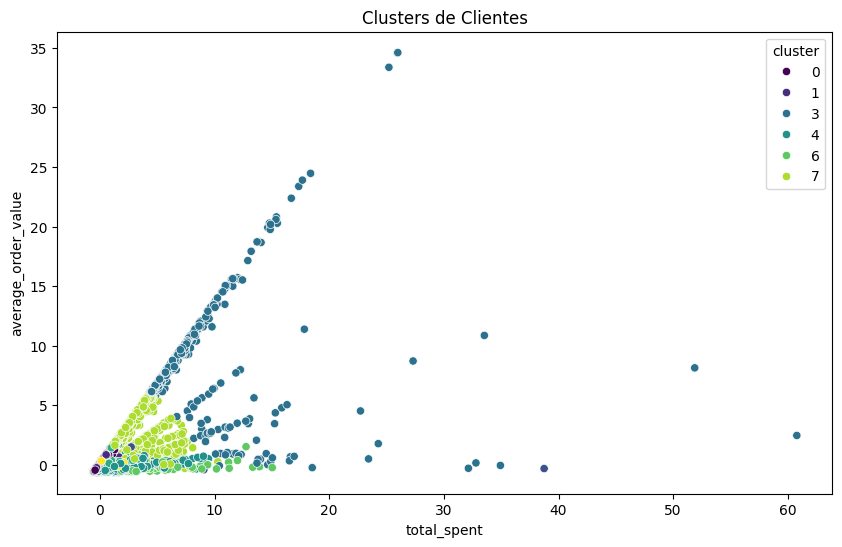

In [ ]:
# Entrenar el modelo K-Means con 9 clusters predeterminados
kmeans = KMeans(n_clusters=9, random_state=42)
clusters = kmeans.fit_predict(customer_df)

# Añadir los clusters al DataFrame original de características
customer_df['cluster'] = clusters

# Mostrar las primeras filas del DataFrame con los clusters añadidos
print(customer_df.head())

# Visualización de los clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_df, x='total_spent', y='average_order_value', hue='cluster', palette='viridis')
plt.title('Clusters de Clientes')
plt.show()

Guardado en un pickle los modelos

In [ ]:
# Guardar el modelo de clustering KMeans
with open('clusterizacion_clientes_model.pkl', 'wb') as model_file:
    pickle.dump(kmeans, model_file)

# Guardar el StandardScaler
with open('clusterizacion_clientes_modelscaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)